# COBRApy

COBRApy is a package for constraint-based modeling of biological networks written in Python.

This tool allows loading and inspecting Genome-Scale Metabolic (GEM) models written in the Systems Biology Markup Language (SBML) format.

Using COBRApy, one can analyze the following model contents:
1. Reactions
2. Metabolites
3. Genes
4. Exchange reactions (Environmental Conditions)

COBRApy allows manipulating the contents of a GEM model. For instance, one can edit reactions' flux bounds, knock out a metabolic gene, or change environmental conditions.

COBRApy contains flux analysis methods to simulate an organism's phenotypic behavior. These include Flux Balance Analysis (FBA), Parsimonious FBA, or Flux Variability Analysis (FVA).

The simulation of gene and reaction deletions for a given GEM model is a straightforward process. One can simulate single or double knockouts using one of the flux analysis methods mentioned above.

## Installation


### Requirements
The following requirements are needed to use COBRApy:
- Python 3.6 or higher
- pip must be installed
- GLPK is the default solver, but CPLEX is preferred


### How to install COBRApy?
```
pip install cobra
```

# Exercise 5 - Phenotype prediction

## Working with a GEM model

For this practical session, we will be using the following model:
- _E. coli_ core model which contains the central carbon metabolism of _Escherichia coli_ -> file: ../data/e_coli_core.xml

You can read more about _E. coli_ core model (Orth et al., 2010) in the following links:
- https://journals.asm.org/doi/10.1128/ecosalplus.10.2.1
- http://bigg.ucsd.edu/models/e_coli_core

This exercise consists of exploring the phenotype prediction tools of COBRApy. Thus, the following steps will be followed:
- Perform an FBA simulation using an aerobic/anaerobic conditions;
- Perform an pFBA simulation;
- Perform an FVA simulation;
- Perform reaction and gene deletions;
- Perform mutant-specific simulation methods, such as ROOM and MOMA;
- Perform single and double deletions
- Perform production envelopes

In [1]:
# imports; to install escher run (pip install escher); if you have this error: ImportError: cannot import name 'soft_unicode' from 'markupsafe' (/home/emanuel/miniforge3/envs/GSMMutils/lib/python3.11/site-packages/markupsafe/__init__.py), run (pip install markupsafe==2.0.1) 
import cobra
import escher

In [34]:
# Loading a model
model_path = 'e_coli_core.xml'
model = cobra.io.read_sbml_model(model_path)

model

Name,e_coli_core
Memory address,171b26010
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


## Phenotype Prediction

COBRApy includes different algorithms for phenotype prediction. These include:
- Flux Balance Analysis (FBA); 
- Parsimonious Flux Balance Analysis (pFBA);
- Flux Variability Analysis (FVA);
- Regulatory On/Off Minimization (ROOM);
- Minimization of Metabolic Adjustment (MOMA);

### Flux Balance Analysis (FBA) - Aerobiosis

First, the exchange reactions should be verified to make sure that the aerobic conditions are all set up in the model.

In [4]:
#inspecting the exchange reactions.
for exchange in model.exchanges:
    print(exchange.name, '->', exchange.bounds)

Acetate exchange -> (0.0, 1000.0)
Acetaldehyde exchange -> (0.0, 1000.0)
2-Oxoglutarate exchange -> (0.0, 1000.0)
CO2 exchange -> (-1000.0, 1000.0)
Ethanol exchange -> (0.0, 1000.0)
Formate exchange -> (0.0, 1000.0)
D-Fructose exchange -> (0.0, 1000.0)
Fumarate exchange -> (0.0, 1000.0)
D-Glucose exchange -> (-10.0, 1000.0)
L-Glutamine exchange -> (0.0, 1000.0)
L-Glutamate exchange -> (0.0, 1000.0)
H+ exchange -> (-1000.0, 1000.0)
H2O exchange -> (-1000.0, 1000.0)
D-lactate exchange -> (0.0, 1000.0)
L-Malate exchange -> (0.0, 1000.0)
Ammonia exchange -> (-1000.0, 1000.0)
O2 exchange -> (-1000.0, 1000.0)
Phosphate exchange -> (-1000.0, 1000.0)
Pyruvate exchange -> (0.0, 1000.0)
Succinate exchange -> (0.0, 1000.0)


In [25]:
# perform an FBA in aerobisis (O2 can be consumed by default in this model; 
# if you want to directly see the documentation of a function you can run help(function_name))

model.optimize()

,fluxes,reduced_costs
PFK,7.477382,1.387779e-17
PFL,0.000000,-1.527746e-02
PGI,4.860861,0.000000e+00
PGK,-16.023526,3.824365e-18
PGL,4.959985,1.301043e-18
...,...,...
NADH16,38.534610,0.000000e+00
NADTRHD,0.000000,-2.546243e-03
NH4t,4.765319,0.000000e+00
O2t,21.799493,0.000000e+00


In [32]:
help(model.optimize)

Help on method optimize in module cobra.core.model:

optimize(objective_sense: Optional[str] = None, raise_error: bool = False) -> 'Solution' method of cobra.core.model.Model instance
    Optimize the model using flux balance analysis.
    
    Parameters
    ----------
    objective_sense : {None, 'maximize' 'minimize'}, optional
        Whether fluxes should be maximized or minimized. In case of None,
        the previous direction is used (default None).
    raise_error : bool
        If true, raise an OptimizationError if solver status is not
         optimal (default False).
    
    Returns
    -------
    Solution
    
    Notes
    -----
    Only the most commonly used parameters are presented here.  Additional
    parameters for cobra.solvers may be available and specified with the
    appropriate keyword argument.



In [10]:
# performing a FBA simulation in aerobiosis; the summary performs an FBA as the optimize, but shows only the exchange fluxes in a table
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


### Flux Balance Analysis (FBA) - Anaerobiosis

Now, we should alter the exchange reactions to anaerobic conditions.

In [12]:
#setting an anaerobic medium
o2_exchange = model.exchanges.get_by_id('EX_o2_e')
o2_exchange.bounds = (0, 1000)   # OR o2_exchange.lower_bound = 0
o2_exchange

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x17f580d10
Stoichiometry,o2_e --> O2 O2 -->
GPR,
Lower bound,0
Upper bound,1000


In [14]:
# performing a FBA simulation in anaerobiosis
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


In [15]:
# now we should revert the model changes to aerobic conditions
o2_exchange.bounds = (-1000, 1000)
o2_exchange

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x17f580d10
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000
Upper bound,1000


### Making reversible changes in the model

All changes performed in a GEM model using CORBApy are irreversible by default.
That is, if we change the bounds of the oxygen exchange reaction, our model will no longer continue under aerobic conditions during this exercise.

However, there is a way to perform reversible changes in a GEM model using COBRApy. For that, one can use the `with` context manager in our `model`. All changes performed within the `with` context manager block will be reverted automatically by COBRApy.

In [16]:
# verifying that we have reverted the model changes to aerobic conditions
o2_exchange = model.exchanges.get_by_id('EX_o2_e')
o2_exchange.bounds

(-1000, 1000)

In [18]:
# making reversible changes in the model
print(f"Before the with: \n{o2_exchange.bounds}")
with model:
    o2_exchange.bounds = (0, 1000)
    print(f"Inside the with: \n{o2_exchange.bounds}")
print(f"After the with \n{o2_exchange.bounds}")

Before the with: 
(-1000, 1000)
Inside the with: 
(0, 1000)
After the with 
(-1000, 1000)


4. Make ACALD irreversible

In [19]:
model.reactions.ACALD.bounds = (0, 1000)

5. Check model medium

In [20]:
# the model.medium shows all bounds to positive values! 
print(model.medium)
print(model.exchanges.EX_o2_e.bounds)
# as you can see the O2 exchange is "open", i.e, O2 can be consumed by default in this model

{'EX_co2_e': 1000.0, 'EX_glc__D_e': 10.0, 'EX_h_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_o2_e': 1000, 'EX_pi_e': 1000.0}
(-1000, 1000)


6. FBA in anaerobic and aerobic conditions

In [22]:
# AEROBIC; As you can see, no acetate, lactate, ethanol, or formate is produced in aerobic conditions
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [23]:
# ANAEROBIC; As you can see, acetate, lactate, and formate are produced in anaerobic conditions
with model:
    model.exchanges.EX_o2_e.bounds = (0, 1000)
    model_summary = model.summary()
model_summary

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.2464,1,0.41%
glc__D_e,EX_glc__D_e,10,6,99.59%
nh4_e,EX_nh4_e,0.752,0,0.00%
pi_e,EX_pi_e,0.5073,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-0.146,2,0.54%
for_e,EX_for_e,-0.8117,1,1.49%
h2o_e,EX_h2o_e,-0.7582,0,0.00%
h_e,EX_h_e,-21.48,0,0.00%
lac__D_e,EX_lac__D_e,-17.76,3,97.97%


### Flux Variability Analysis (FVA)

FBA can only obtain a unique flux distribution for a given objective function. Nevertheless, the space of flux distributions is very large and can vary significantly for a different objective. _FVA_ is a simulation method that finds the possible flux range for each reaction. _FVA_ can be used from the flux analysis package `cobra.flux_analysis.flux_variability_analysis(model)`. Note that, _FVA_ allows setting a minimum value of growth rate. In this case, we will be using 10% (that is, 0.1) of the wild-type growth rate.

In [24]:
# performing fva simulation
fva_solution = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.1)
fva_solution

,minimum,maximum
PFK,0.000000,160.068737
PFL,0.000000,37.765356
PGI,-46.033227,9.982085
PGK,-19.767685,-1.095915
PGL,0.000000,56.015311
...,...,...
NADH16,0.000000,112.359899
NADTRHD,0.000000,341.373936
NH4t,0.476532,9.812417
O2t,0.000000,56.179949


In [32]:
# maximum theoretical production rates of Acetate (EX_ac_e), Ethanol (EX_etoh_e), and Formate (EX_for_e)

print(f'Maximum theoretical production rate of Acetate:', fva_solution.loc['EX_ac_e', 'maximum'], 'mmol/gDW/h')
print(f'Maximum theoretical production rate of Ethanol:', fva_solution.loc['EX_etoh_e', 'maximum'], 'mmol/gDW/h')
print(f'Maximum theoretical production rate of Formate:', fva_solution.loc['EX_for_e', 'maximum'], 'mmol/gDW/h')
print(f'Maximum theoretical production rate of Lactate:', fva_solution.loc['EX_lac__D_e', 'maximum'], 'mmol/gDW/h')

Maximum theoretical production rate of Acetate: 18.671770397634027 mmol/gDW/h
Maximum theoretical production rate of Ethanol: 0.0 mmol/gDW/h
Maximum theoretical production rate of Formate: 37.76535648903652 mmol/gDW/h
Maximum theoretical production rate of Lactate: 18.671770397634035 mmol/gDW/h


In [29]:
# alternative:
model.summary(fva=0.1)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,[1.42; 10],6,100.00%
nh4_e,EX_nh4_e,4.765,[0.4765; 9.812],0,0.00%
o2_e,EX_o2_e,21.8,[0; 56.18],0,0.00%
pi_e,EX_pi_e,3.215,[0.3215; 3.215],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux
ac_e,EX_ac_e,0,[-18.67; 0],2,0.00%
akg_e,EX_akg_e,0,[-9.336; 0],5,0.00%
co2_e,EX_co2_e,-22.81,[-56.28; 9.686],1,100.00%
for_e,EX_for_e,0,[-37.77; 0],1,0.00%
glu__L_e,EX_glu__L_e,0,[-9.336; 0],5,0.00%


In [30]:
# ANAEROBIC; As you can see, acetate, lactate, and formate are produced in anaerobic conditions
with model:
    model.exchanges.EX_o2_e.bounds = (0, 1000)
    model_summary = model.summary(fva=0.1)
model_summary

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
co2_e,EX_co2_e,0.2464,[0.01004; 10.88],1,0.41%
glc__D_e,EX_glc__D_e,10,[4.776; 10],6,99.59%
nh4_e,EX_nh4_e,0.752,[0.0752; 3.062],0,0.00%
pi_e,EX_pi_e,0.5073,[0.05073; 0.5073],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux
ac_e,EX_ac_e,-0.146,[-9.903; 0],2,0.54%
akg_e,EX_akg_e,0,[-2.349; 0],5,0.00%
for_e,EX_for_e,-0.8117,[-9.969; 0],1,1.49%
glu__L_e,EX_glu__L_e,0,[-2.986; 0],5,0.00%
h2o_e,EX_h2o_e,-0.7582,[-10.09; -0.07582],0,0.00%


### Parsimonious Flux Balance Analysis (pFBA)

pFBA simulations gives the optimal growth rate, while minimizing the total sum of fluxes.
pFBA can be used from the flux analysis package `cobra.flux_analysis.pfba(model)`.

In [34]:
#performing pfba simulation
pfba_solution = cobra.flux_analysis.pfba(model)
pfba_solution.objective_value

518.4220855176065

The optimal solution of the pFBA is considerably different from the FBA result. This happens because the objective value for the pFBA is defined as the sum of all flux values (`sum(abs(pfba_solution.fluxes.values))`). On the other hand, the FBA result corresponds to the flux value of the reaction that is being optimized (`fba_solution.fluxes["BIOMASS_Ecoli_core_w_GAM"]`).

In [35]:
#calculating the objective value of a pFBA solution
sum(abs(pfba_solution.fluxes.values))

518.4220855176065

### Simulating Deletions

As previously mentioned, COBRApy can be used to simulate gene or reaction deletions. The function `knock_out()` can be used to knock out a given reaction or gene.

In [36]:
#knock out the SUCDi reaction
with model:
    model.reactions.SUCDi.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('SUCDi mutant growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('SUCDi flux rate: ', pfba_solution.fluxes['SUCDi'])
    print('SUCDi mutant succinate production rate: ', pfba_solution.fluxes['EX_succ_e'])

SUCDi mutant growth rate:  0.8142975075325306
SUCDi flux rate:  0.0
SUCDi mutant succinate production rate:  0.0


In [37]:
# knock out the b1852 gene associated with reaction G6PDH2r
with model:
    model.genes.b1852.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('b1852 mutant growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('G6PDH2r flux rate: ', pfba_solution.fluxes['G6PDH2r'])
    print('b1852 mutant succinate production rate: ', pfba_solution.fluxes['EX_succ_e'])

b1852 mutant growth rate:  0.8638133095040007
G6PDH2r flux rate:  0.0
b1852 mutant succinate production rate:  0.0


Gene-Protein-Reaction (GPR) rules can be used to understand which genes are associated with a given reaction. Besides, one can understand by the GPR rule if the reaction is being catalyzed by a single gene, isoenzyme or protein complex. In COBRApy, one can inspect the GPR rule of a given reaction or which reactions are associated with a given gene.

In [38]:
# ACKr GPR rule. This reaction is being catalyzed by an isoenzyme
model.reactions.ACKr.gene_reaction_rule

'b3115 or b2296 or b1849'

In [39]:
# knock out the b3115 & b2296 & b1849 genes associated with reaction ACKr
with model:
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('b3115, b2296, b1849 mutant growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('ACKr flux rate: ', pfba_solution.fluxes['ACKr'])
    print('b3115, b2296, b1849 mutant succinate production rate: ', pfba_solution.fluxes['EX_succ_e'])

b3115, b2296, b1849 mutant growth rate:  0.8739215069684305
ACKr flux rate:  0.0
b3115, b2296, b1849 mutant succinate production rate:  0.0


In [3]:
# performing all deletions at once to verify succinate production rate, EX_succ_e
with model:
    wt_pfba_solution = cobra.flux_analysis.pfba(model)
    print('WT growth rate: ', wt_pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('WT succinate production rate: ', wt_pfba_solution.fluxes['EX_succ_e'])
    model.reactions.SUCDi.knock_out()
    model.genes.b1852.knock_out()
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    mutant_pfba_solution = cobra.flux_analysis.pfba(model)
    print('MUTANT growth rate: ', mutant_pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('MUTANT succinate production rate: ', mutant_pfba_solution.fluxes['EX_succ_e'])

WT growth rate:  0.8739215069684302
WT succinate production rate:  0.0
MUTANT growth rate:  0.5744343043406851
MUTANT succinate production rate:  5.63473011273905


### MOMA and ROOM

COBRApy includes phenotype prediction methods that are used predict the flux distribution after a gene knock out. These are the Minimization of Metabolic Adjustment (MOMA), which can be called using `cobra.flux_analysis.moma()`, and Regulatory On/Off Minimization (ROOM), using `cobra.flux_analysis.room()`.

In [12]:
#using MOMA with COBRApy
with model:
    pfba_solution = cobra.flux_analysis.pfba(model)
    model.reactions.SUCDi.knock_out()
    model.genes.b1852.knock_out()
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    moma_result = cobra.flux_analysis.moma(model, pfba_solution)
    print('MOMA Result: ', moma_result)

MOMA Result:  <Solution 176.082 at 0x7f11dbb13910>


In [13]:
model.summary(moma_result)

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,1.827,0,0.00%
o2_e,EX_o2_e,19.27,0,0.00%
pi_e,EX_pi_e,1.232,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-15.93,1,34.82%
h2o_e,EX_h2o_e,-25.82,0,0.00%
h_e,EX_h_e,-21.63,0,0.00%
succ_e,EX_succ_e,-7.455,4,65.18%


In [14]:
#using ROOM with COBRApy
with model:
    pfba_solution = cobra.flux_analysis.pfba(model)
    model.reactions.SUCDi.knock_out()
    model.genes.b1852.knock_out()
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    room_result = cobra.flux_analysis.room(model, pfba_solution)
    print('ROOM Result: ', room_result)

ROOM Result:  <Solution 39.000 at 0x7f11da096790>


In [15]:
model.summary(room_result)

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,8.025,6,100.00%
nh4_e,EX_nh4_e,4.909,0,0.00%
o2_e,EX_o2_e,10.16,0,0.00%
pi_e,EX_pi_e,1.193,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
acald_e,EX_acald_e,-0.001,2,0.01%
akg_e,EX_akg_e,-2.417,5,35.19%
co2_e,EX_co2_e,-6.547,1,19.06%
glu__L_e,EX_glu__L_e,-3.141,5,45.72%
h2o_e,EX_h2o_e,-20.03,0,0.00%


### Single Deletions

Single gene and reaction deletions can also be simulated with the flux analysis package of COBRApy. To do so, one can use the `cobra.flux_analysis.single_gene_deletion()` and `cobra.flux_analysis.single_reaction_deletion()` methods.

In [16]:
#single reaction deletion
reaction_deletion_results = cobra.flux_analysis.single_reaction_deletion(model)
reaction_deletion_results

,ids,growth,status
0,{PPS},0.873922,optimal
1,{NADTRHD},0.873922,optimal
2,{RPE},0.865716,optimal
3,{EX_glu__L_e},0.873922,optimal
4,{PFK},0.704037,optimal
...,...,...,...
90,{H2Ot},0.383515,optimal
91,{EX_h_e},0.000000,optimal
92,{RPI},0.000000,optimal
93,{EX_pi_e},0.000000,optimal


In [17]:
#single gene deletion
gene_deletion_results = cobra.flux_analysis.single_gene_deletion(model)
gene_deletion_results

,ids,growth,status
0,{b0451},0.873922,optimal
1,{b0979},0.873922,optimal
2,{b1479},0.873922,optimal
3,{b2458},0.873922,optimal
4,{b1241},0.873922,optimal
...,...,...,...
132,{b4153},0.873922,optimal
133,{b4077},0.873922,optimal
134,{b3213},0.873922,optimal
135,{b0723},0.814298,optimal


It is worth noting that genes and reactions with a growth rate equal to zero can be considered as essential genes or essential reactions, respectively.

### Double Deletions

Double gene and reaction deletions can also be simulated with the flux analysis package of COBRApy. To do so, one can use the `cobra.flux_analysis.double_gene_deletion()` and `cobra.flux_analysis.double_reaction_deletion()` methods. These methods perform all possible combinations.

In [18]:
#double reaction deletion
double_reaction_deletion_results = cobra.flux_analysis.double_reaction_deletion(model)
double_reaction_deletion_results

,ids,growth,status
0,"{CYTBD, ME2}",0.211663,optimal
1,"{LDH_D, PPS}",0.873922,optimal
2,"{PFL, CS}",0.000000,optimal
3,"{ME2, FORt}",0.873922,optimal
4,"{EX_mal__L_e, RPI}",0.000000,optimal
...,...,...,...
4555,"{FUM, FRUpts2}",0.814298,optimal
4556,"{ME2, TKT1}",0.864759,optimal
4557,"{H2Ot, GLUt2r}",0.383515,optimal
4558,"{EX_etoh_e, PYRt2}",0.873922,optimal


In [19]:
#double gene deletion
double_gene_deletion_results = cobra.flux_analysis.double_gene_deletion(model)
double_gene_deletion_results

,ids,growth,status
0,"{b0902, b1702}",0.873922,optimal
1,"{b0978, b1849}",0.873922,optimal
2,"{b3114, b0979}",0.873922,optimal
3,"{b2779, b1854}",0.000000,optimal
4,"{b3212, b2133}",0.873922,optimal
...,...,...,...
9448,"{b1779, b0755}",0.000000,optimal
9449,"{b0811, b1276}",0.873922,optimal
9450,"{b4301, b3115}",0.873922,optimal
9451,"{b2277, b1702}",0.211663,optimal


### Production envelopes

Production Envelopes can be used to show distinct phases of optimal growth as a function of the consumption rate of other metabolites. In COBRApy, one can use the method `production_envelope` from the flux analysis package.

In [20]:
# Production envelope for Acetate production as a function of oxygen consumption rate
prod_env = cobra.flux_analysis.production_envelope(model, ["EX_o2_e"], objective="EX_ac_e", carbon_sources="EX_glc__D_e")
prod_env.head()

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_o2_e
0,EX_glc__D_e,0.0,0.0,0.0,0.000000,0.000000,0.000000,-60.000000
1,EX_glc__D_e,0.0,0.0,0.0,1.578947,0.052632,0.051748,-56.842105
2,EX_glc__D_e,0.0,0.0,0.0,3.157895,0.105263,0.103496,-53.684211
3,EX_glc__D_e,0.0,0.0,0.0,4.736842,0.157895,0.155245,-50.526316
4,EX_glc__D_e,0.0,0.0,0.0,6.315789,0.210526,0.206993,-47.368421


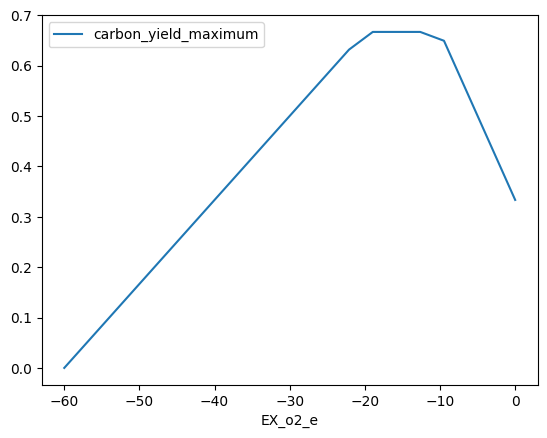

In [23]:
# the production envelope can be visualized in a plot as follows:
prod_env.plot(kind='line', x='EX_o2_e', y='carbon_yield_maximum');